In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import zipfile
import datetime as dt
import konlpy
import re
import cartopy.crs as ccrs  ##  Cartopy의 좌표 참조 시스템을 ccrs로 가져옴
import cartopy.feature as cfeature  ## Cartopy의 지형 및 해양 기능을 cfeature로 가져옴
from scipy.spatial import distance
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime, date, time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from konlpy.tag import Okt

plt.rc('font', family='malgun gothic')    # 한글처리
plt.rcParams['axes.unicode_minus']=False  # '- 표시


In [3]:
## 훈련용 데이터 파일
nsmc_train_df = pd.read_csv('data/senti/ratings_train.txt', encoding='utf8', sep='\t')#, engine='python')
nsmc_train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [4]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]

In [6]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [7]:
nsmc_train_df['label'].value_counts()

0    75170
1    74825
Name: label, dtype: int64

In [8]:
nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
### 평가용 데이터
nsmc_test_df = pd.read_csv('data/senti/ratings_test.txt', encoding='utf8', sep='\t', engine='python')
nsmc_test_df.head()


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
nsmc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [11]:
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()]

In [12]:
print(nsmc_test_df['label'].value_counts())

1    25171
0    24826
Name: label, dtype: int64


In [13]:
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', "", x))

In [14]:
nsmc_test_df.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0


In [15]:
okt = Okt()

def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])

In [17]:
from sklearn.linear_model import LogisticRegression

SA_lr = LogisticRegression(random_state = 0)

In [18]:
SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

LogisticRegression(random_state=0)

In [19]:
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)


In [20]:
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [21]:
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

{'C': 3} 0.8553


In [22]:
# 최적 파라미터의 best 모델 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

In [23]:
###  분석 모델 평가  ###

In [28]:
# 평가용 데이터의 피처 벡터화
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

## TF-IDF  : 텍스트를 수치화하는 방법 중 하나, 단어의 상대적인 중요성을 나타내는 값

In [29]:
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

In [30]:
from sklearn.metrics import accuracy_score

print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.857


In [31]:
st = input('감성 분석할 문장입력 >> ')
# (웃자 ^o^ 오늘은 좋은 날이 될 것 같은 예감100%! ^^* ) 입력

감성 분석할 문장입력 >>  웃자 ^o^ 오늘은 좋은 날이 될 것 같은 예감100%! ^^*


In [32]:
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st)
print(st)
st = [" ".join(st)]
print(st)

['웃자', '오늘은', '좋은', '날이', '될', '것', '같은', '예감']
['웃자 오늘은 좋은 날이 될 것 같은 예감']


In [33]:
# 1) 입력 텍스트의 피처 벡터화
st_tfidf = tfidf.transform(st)

# 2) 최적 감성분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)

In [34]:
# 3) 예측 값 출력하기
if(st_predict== 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

['웃자 오늘은 좋은 날이 될 것 같은 예감'] ->> 긍정 감성


In [35]:
### 1. 파일 불러온 후, 분석할 컬럼을 추출하여 데이터 프레임에 저장
data_df = pd.read_csv('data/senti/코로나_naver_news.csv')
data_df.head(3)

,title,description
0,결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;,"<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 ..."
1,"창녕군, ‘창녕형’비대면 선별진료소 운영",▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,"DK모바일, 메인 홍보 모델로 AOA '설현' 선정","한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’..."


In [36]:
### 2. 한글 이외 문자 제거
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

data_df.head(3)

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...


In [37]:
### 3. 'title'에 대한 감성 분석

# 1) 분석할 데이터의 벡터화 ---<< title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])

# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['title_label'] = data_title_predict

data_df.head(3)

,title,description,title_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0


In [38]:
### 4. 'description' 에 대한 감성 분석

# 1) 분석할 데이터의 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])

# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['description_label'] = data_description_predict

data_df.head(3)

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0,0


In [39]:
### 5. 분석 결과가 추가된 데이터프레임을 CSV 파일로 저장

data_df.to_csv('data/senti/코로나_naver_news_label.csv', encoding='euc-kr') 

In [40]:
### 6. 감성 분석 결과 확인
data_df.head()

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0,0
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...,0,1
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...,0,0


In [41]:
print(data_df['title_label'].value_counts())

0    485
1    315
Name: title_label, dtype: int64


In [42]:
print(data_df['description_label'].value_counts())

0    430
1    370
Name: description_label, dtype: int64


In [43]:
### 7. 결과 저장 : 긍정과 부정을 분리하여 CSV 파일로 저장

columns_name = ['title','title_label','description','description_label']
NEG_data_list = []
POS_data_list = []

for i, data in data_df.iterrows(): 
    title = data["title"] 
    description = data["description"] 
    t_label = data["title_label"] 
    d_label = data["description_label"] 
    
    if d_label == 0: # 부정 감성 샘플만 추출
        NEG_data_list.append([title, t_label, description, d_label])
    else: # 긍정 감성 샘플만 추출
        POS_data_list.append([title, t_label, description, d_label])
     
NEG_data_df = pd.DataFrame(NEG_data_list, columns=columns_name)
POS_data_df = pd.DataFrame(POS_data_list, columns=columns_name)

# 파일에 저장
NEG_data_df.to_csv('data/senti/코로나_naver_news_NEG.csv', encoding='euc-kr', index=False) 
POS_data_df.to_csv('data/senti/코로나_naver_news_POS.csv', encoding='euc-kr', index=False) 


In [44]:
len(NEG_data_df), len(POS_data_df)

(430, 370)

In [47]:
### 8. 긍정 감성의 데이터에서 명사만 추출하여 정리

POS_description = POS_data_df['description']
POS_description.head(3)

0    변화의 핵심 중에서는 우리 사회가 신종  코로나 바이러스 감염증 코로나 의 위기를 ...
1    한편   코로나 로 인한 해외의 식재료 사재기에서 보듯이 국민들의 먹거리를 안정적으...
2    최근 갤러리 현대 창업  주년 기념전에 이 작품이 전시되자  코로나 의 영향에도 마...
Name: description, dtype: object

In [48]:
POS_description_noun_tk = []
for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출
    

POS_description_noun_join = []
for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1인 토큰은 제외
    POS_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성
    
print(POS_description_noun_join)  

['변화 핵심 우리 사회 신종 코로나 바이러스 감염증 코로나 위기 마주 언제 미래 국가 국민 어려움 해결 저희', '한편 코로나 해외 재료 사재기 국민 먹거리 안정 생산 포스트 코로나 과제 부각 농민 기본소득 도입 통해 안정 생산 기반 확충', '최근 갤러리 현대 창업 주년 기념 작품 전시 코로나 영향 마스크 착용 관람객 미술 트렌드 한국 미술 시장 정태희 서울 옥션 스페셜리스트 세계 경기 침체 코로나 여파', '코로나 감안 면접 비대 역량 검사 도입 국내 최대 치킨 프랜차이즈 제너시스 비비큐 회장 채용 관계자 한국 대표 책임감 브랜드 로서 코로나 침체 채용 분위기', '오후 서울 중랑구 의료 의료 잠시 콘서트 신종 코로나 바이러스 감염증 코로나 환자 진료 위해 수고 의료 가수 공연 보고 뉴스', '플립 러닝 온라인 학습 교실 토론 심화 학습 거꾸로 교실 불리 포스트 코로나 시대 교육 방식 주목 아르고 리더십 상황 게임 통해 리더십 유형', '도배 장판 침대 장롱 가구 교체 코로나 예방 방역 진행 주거 환경 조성 미자 양동 동장 이웃 위해 봉사', '코로나 사태 가운데 병영 생활 손흥민 경험 영국 화제 손흥민 서로 금방 이서 정말 서로 호흡', '청와대 해외 보가 문재인 대통령 포스트 코로나 시대 경제위기 정상회담 통해 양국 협력 에너지 의료 확장 최근 카타르 코로나 관련', '맥도날드 코로나 방역 작업 대구 지하철 청소 근로자 빅맥 커피 증정 패션 업계 나눔 활동 동참 코오롱 인더스 트리 직원 성과 상금 만원 코로나 어려움', '정하영 김포시 혁신 교육 지구 사업 특수교육 대상자 사업 별도 편성 소외 학생 면서 코로나 교육과정 운영 판단 학생 안전 방역', '군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포로 번길 거주 자료 군포 시청 군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포 시청 공식 블로그 통해 서울시', '명품 함양 양파 특판전 모습 사진 제공 함양군 함양군 롯데 마트 서울 역점 양파 소비 촉진 판촉 행사 코로나 농심 위로 함양군

In [50]:
### 9. 부정 감성의 데이터에서 명사만 추출하여 정리

NEG_description = NEG_data_df['description']

NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출
    
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]  #길이가 1인 토큰은 제외
    NEG_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성
    
print(NEG_description_noun_join)    

['코로나 경제 위기 대응 위해 국세 수입 정부 재정 마련 대한 우려 때문 한국 개발 국책 연구기관 증세 화두 정부 여당 증세', '지난 창녕군 보건소 설치 진료 검사 체온 측정 사진 제공 창녕군 코로나 장기 대비 비대 진료 도입 경남 창녕군 지난 도내 최초 코로나 진료', '한편 설현 최근 코로나 바이러스 시리즈 세계 유행 다큐멘터리 내레이션 처음 도전 호평 드라마 출연 검토 게임 이벤트 대한', '이재 고용노동부 장관 코로나 긴급 고용 안정 원금 서울 센터 서울 중구 방문 이번 현장 방문 코로나 긴급 고용 안정 원금 신청 시작 이틀', '올해 신종 코로나 바이러스 감염증 코로나 여파 오프라인 행사 진행 공식 채널 통해 명칭 초청 리스트 공개 한편 반도 국내외', '경찰 코로나 감염 우려 이상 집회 봉쇄 지난 홍콩 국가보안법 시위 홍콩 경찰 코로나 확산 올해 불허 상황 처음 주최', '전국 컨테이너 처리 국내 항만 신종 코로나 바이러스 감염증 코로나 사태 본격 물동량 부진 와중 인천 중국 항만 정상화', '이용 의원 제공 이용 민주당 내부 대표 코로나 시화 장기 생활 방역 면서 코로나 현장 의료 진의 근무 환경 부당 처우 과중 노동 강도 인력 부족 문제', '코로나 사태 지속 한의대 강의 역시 대부분 대면 대면 실습 강의실 풍경 예전 현재 코로나 대부분 학과 수업 대면', '이번 행사 코로나 확대 장기 화로 지역 소비 판로 어려움 농가 돕기 소비 촉진 위해 마련 행사 계란 연근 감자 새송이 방울토마토 깻잎 양파 오이 고추 품목', '세계 코로나 전례 위기 이로 국내외 영화계 예상 타격 부산 국제 영화제 국내외 상황 인지 예의 주시 정부 방침 권고 준수', '서울 경기 인천 수도권 개척 교회 신종 코로나 바이러스 감염증 코로나 진자 산발 증가 모양새 감염 경로 진자 방역 당국 긴장', '신종 코로나 바이러스 감염증 코로나 장기 화로 전통 시장 상인 매출 감소 점포 운영 어려움 투입 오프라인 무료 배송 서비스 운영 지원 지원 대상 남성 사계 시장', '수도권 중

In [51]:
### 10. 긍정 감성 데이터에 대한 dtm(Document-Term Matrix) 구성 : 단어 벡터 값을 내림차순으로 정렬
###  dtm : 단어들의 출현 빈도, 텍스트 데이터를 수치화

POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_vocab = dict() 

for idx, word in enumerate(POS_tfidf.get_feature_names_out()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()


POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)
POS_words    

[('코로나', 29.58865817494428),
 ('의료', 13.461836434575911),
 ('위해', 11.469142512665115),
 ('바이러스', 9.626197092990505),
 ('신종', 9.241355937335499),
 ('감염증', 8.876275469712054),
 ('온라인', 7.6638009611810896),
 ('시대', 7.638747100423279),
 ('확산', 7.462304300911354),
 ('사회', 7.331187766652533),
 ('이번', 6.953637262299177),
 ('지역', 6.7931464306235565),
 ('어려움', 6.57884559465247),
 ('통해', 6.500569971401247),
 ('극복', 6.067323212381158),
 ('포스트', 6.02648184365831),
 ('기업', 5.899827006908783),
 ('서울', 5.432782197187217),
 ('사태', 5.340689961243574),
 ('방역', 5.308659591090857),
 ('최근', 5.285143543921558),
 ('언택트', 5.185701361355053),
 ('상황', 5.129043847943381),
 ('환자', 5.111079129368619),
 ('정부', 5.069719087512996),
 ('사업', 5.045688264465154),
 ('경제', 5.043712031592348),
 ('생활', 5.034230080207947),
 ('대표', 5.031840422108942),
 ('올해', 5.011379038211078),
 ('공연', 4.936538589036854),
 ('우리', 4.898794126455551),
 ('비대', 4.802827030463792),
 ('한국', 4.770201020213962),
 ('개발', 4.767977722488553),
 ('진자', 4.

In [52]:
### 11. 부정 감성 데이터의 dtm 구성 

NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

NEG_vocab = dict() 

for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
    
NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)
NEG_words 

[('코로나', 34.56440043805242),
 ('바이러스', 15.755970871602138),
 ('신종', 14.29640382643984),
 ('감염증', 14.034156174169826),
 ('위해', 11.557221696267494),
 ('확산', 9.566148700015386),
 ('대종상영화제', 9.131196736061566),
 ('사태', 8.511012953112722),
 ('진행', 8.501455300356248),
 ('지역', 8.02051798313098),
 ('방역', 7.786170139849359),
 ('지난', 7.563662184925654),
 ('참석', 7.320037542811409),
 ('진자', 7.019841914588245),
 ('이번', 6.942817107419809),
 ('여파', 6.7290204781835925),
 ('감염', 6.669203919601509),
 ('지원', 6.501810225977662),
 ('예방', 6.39663153382676),
 ('경제', 5.6993577091405525),
 ('최근', 5.577762429272219),
 ('서울', 5.119380466737213),
 ('생활', 5.040220383692727),
 ('마스크', 4.990391941347541),
 ('대응', 4.958683224918504),
 ('장기', 4.865605387946561),
 ('가운데', 4.806733078391168),
 ('정부', 4.690520671438856),
 ('상황', 4.67552454891047),
 ('시장', 4.660874586002851),
 ('어려움', 4.633706079944705),
 ('발생', 4.558656374995721),
 ('로봇', 4.52985529979186),
 ('운영', 4.52088415417818),
 ('위기', 4.498382001461058),
 ('클라우드',

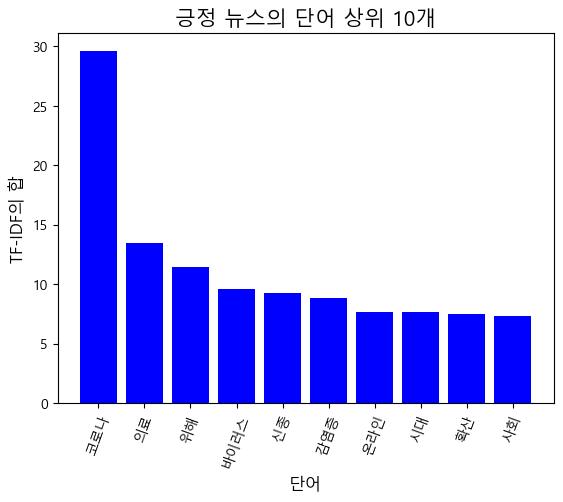

In [53]:
### 12. 긍정 감성 단어의 상위 10개 단어로 바 차트 그리기

max_words = 10  # 차트에 나타낼 단어 개수

plt.bar(range(max_words), [i[1] for i in POS_words[:max_words]], color="blue")
plt.title("긍정 뉴스의 단어 상위 %d개" % max_words, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max_words), [i[0] for i in POS_words[:max_words]], rotation=70)

plt.show()

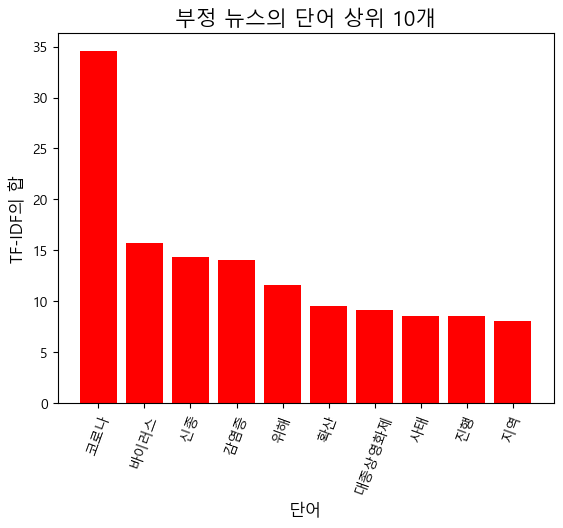

In [54]:
### 13. 부정 감성 단어의 상위 10개 단어로 바 차트 그리기

max_words = 10  # 차트에 나타낼 단어 개수

plt.bar(range(max_words), [i[1] for i in NEG_words[:max_words]], color="red")
plt.title("부정 뉴스의 단어 상위 %d개" % max_words, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max_words), [i[0] for i in NEG_words[:max_words]], rotation=70)

plt.show()